# Closure bars

In [13]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine
from math import ceil

import matplotlib.pyplot as plt
import matplotlib.colors as cl
from matplotlib.ticker import FormatStrFormatter

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob

import m2lib22.box as box
import m2lib22.aviso as aviso
import m2lib22.cstes as cstes
import m2lib22.diagnosis as diag
import m2lib22.erastar as eras
import m2lib22.stress_to_windterm as stw

from m2lib22.cstes import labels, zarr_dir

plt.rcParams.update({'font.size':15})

In [14]:
if False:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster(cores=56, processes=28, walltime='04:00:00')
    #cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    w = cluster.scale(jobs=3)
else:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 56,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:59440,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 56
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:41786,Total threads: 7
Dashboard: http://127.0.0.1:57476/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:50523,


## IMPORT DATA, build dataset

In [22]:
def plot_closure_bar(ds, id_, ax, title=1):

    dic = ds['rms_sum_'+id_].attrs
    acc = 'rms_'+dic['acc']
    cor = 'rms_'+dic['coriolis']
    ggrad = 'rms_'+dic['ggrad']
    wd = 'rms_'+dic['wind']

    # ACC X
    ax.bar(1.5, (ds[acc] + ds['rms_exc_acc_' + id_])**2,
           color ='lightgrey', width = 0.45, zorder=3, align = 'center',bottom = (ds[acc] - ds['rms_exc_acc_' + id_])**2)
    ax.bar(1.5, ds['rms_exc_acc_' + id_]**2,
           color = 'lightsteelblue', width = 0.4, zorder=3, align = 'center')
    ax.bar(1.5, ds[acc]**2, bottom = ds['rms_exc_acc_' + id_]**2,
           color = 'red', width = 0.4, zorder=3, align = 'center')

    # CORIOLIS
    ax.bar(2, (ds['rms_exc_coriolis_' + id_] + ds[cor])**2,
           color='lightgrey', width = 0.45, zorder=3, align = 'center', bottom =(ds['rms_exc_coriolis_' + id_] - ds[cor])**2 )
    ax.bar(2, ds['rms_exc_coriolis_' + id_]**2,
           color = 'lightsteelblue', width = 0.4, zorder=3, align = 'center')
    ax.bar(2, ds[cor]**2, bottom = ds['rms_exc_coriolis_' + id_]**2,
           color = 'green', width = 0.4, zorder=3, align = 'center')

    # G GRADIENT SLA
    ax.bar(2.5, (ds['rms_exc_ggrad_' + id_] + ds[ggrad])**2,
           color ='lightgrey', width = 0.45, zorder=3, align = 'center', bottom = (ds['rms_exc_ggrad_' + id_] - ds[ggrad])**2)
    ax.bar(2.5, ds['rms_exc_ggrad_' + id_]**2,
           color = 'lightsteelblue', width = 0.4, zorder=3, align = 'center')
    ax.bar(2.5, ds[ggrad]**2, bottom = ds['rms_exc_ggrad_' + id_]**2,
           color = 'c', width = 0.4, zorder=3, align = 'center')

    # WIND
    ax.bar(3, (ds['rms_exc_wind_' + id_] + ds[wd])**2,
           color ='lightgrey', width = 0.45, zorder=3, align = 'center', bottom = (ds['rms_exc_wind_' + id_] - ds[wd])**2)
    ax.bar(3, ds['rms_exc_wind_' + id_]**2,
           color = 'lightsteelblue', width = 0.4, zorder=3, align = 'center')
    ax.bar(3, ds[wd]**2, bottom = ds['rms_exc_wind_' + id_]**2,
           color = 'mediumvioletred', width = 0.4, zorder=3, align = 'center')
    
    #SUM of rms^2
    ax.bar(1,ds[acc]**2,
           color = 'red', width = 0.4, zorder=3, align = 'center')
    ax.bar(1, ds[cor]**2, bottom = ds[acc]**2,
           color = 'green', width = 0.4, zorder=3, align = 'center')
    ax.bar(1, ds[ggrad]**2, bottom = ds[acc]**2+ds[cor]**2,
           color = 'c', width = 0.4, zorder=3, align = 'center')
    ax.bar(1, ds[wd]**2, bottom = ds[acc]**2+ds[cor]**2+ds[ggrad]**2,
           color = 'mediumvioletred', width = 0.4, zorder=3, align = 'center')
    Ss=ds[acc]**2+ds[cor]**2+ds[ggrad]**2+ds[wd]**2
    ax.text(0.75, Ss+Ss/30, str(np.format_float_scientific(Ss.values,precision = 3)))

    ax.set_ylabel(r'Mean square $\langle ...^2 \rangle$ [$m^2/s^4$]')
    if isinstance(title, int): ax.set_title(id_)
    else : ax.set_title(title+'\n'+id_+'\n')
    
    #TOTAL
    S = ds['rms_sum_'+id_]**2
    ax.bar(0.5, S, color ='k',width = 0.4, zorder=3)
    ax.text(0.25, S+S/20, str(np.format_float_scientific(S.values,precision = 3)))
    ax.axhline(y=S, c="k", linewidth=2, ls=':', zorder=4)
    
    #ax.set_ylim((0,8e-5))
    ax.grid(axis='y', zorder=0)
    
    N=np.arange(0.5,3.5, 0.5) 
    g = ds[ggrad].attrs['long_name'].replace('rms[',r'').replace(']','').replace('altimatchup','aviso').replace('driftermatchup','aviso').split('+')
    ggrad_tick='$\n $+'.join(g)
    #w = ds_all['rms_es_cstrio_z15_alti_wd_x'].attrs['long_name'].replace('rms[',r'').replace(']','').split(' from')
    #wd_tick = '\n from'.join(w)
    ticks = (r'$\langle S^2\rangle$',r'$\sum_x \langle x^2\rangle$',r'$d_tu$', r'$-fv$', ggrad_tick, r'$\frac{1}{\rho}\partial_z\tau_x$')
    ax.set_xticks(N, ticks,)

    print(f'acc:{ds[acc].values**2}, coriolis:{ds[cor].values**2}, ggrad:{ds[ggrad].values**2}, wind:{ds[wd].values**2}')

In [15]:
def plot_comp_closure_bar(ds, ID, fig_title=1, titles=1, ncols=2, figsize='default', bottom = 0.15, loc='lower center'):
    if titles==1 : titles=np.ones_like(ID)
    
    nrows = ceil(len(ID)/ncols)
    
    if figsize=='default':
        # Define the figure and each axis for the 3 rows and 3 columns
        fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                            sharey='all',
                            figsize=(ncols*6,nrows*7))
    else:        
        # Define the figure and each axis for the 3 rows and 3 columns
        fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                            sharey='all',
                            figsize=figsize)

    # axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
    axs=axs.flatten()
    

    #Loop over all of the variables
    for i in range(len(ID)):
        plot_closure_bar(ds, ID[i],axs[i], title=titles[i])
    if isinstance(fig_title, str):
        fig.suptitle(fig_title)
         
    # Delete the unwanted axes
    for i in np.arange(len(ID),nrows*2):
        fig.delaxes(axs[i])
        
    colors=['k', 'lightsteelblue','lightgrey', 'red', 'green', 'c','mediumvioletred']
    labels_ = [r'$\langle S^2\rangle$',
           r'$\langle S_{-x}^2\rangle$',
           r'$[(\sqrt{\langle S_{-x}^2\rangle}-\sqrt{\langle x^2\rangle})^2,(\sqrt{\langle S_{-x}^2\rangle}+\sqrt{\langle x^2\rangle})^2$]',
           r'$\langle (x=d_tu)^2\rangle $ from drifters',
          r'$\langle (x=-fv)^2\rangle$ from drifters',
          r"$\langle (x=g\partial_x\eta)^2\rangle$",
           r"$\langle (x=\frac{1}{\rho}\partial_z\tau_x)^2\rangle$",
          ]                                                                                                                                                           
             
    handles = [plt.Rectangle((0,0),1,1, color=colors[i]        ) for i in range(len(labels_))]
    fig.legend(handles, labels_, ncol=3, loc=loc)#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
    fig.tight_layout(rect=[0,bottom,1,1])#left, bottom, right, top (default is 0,0,1,1)

In [16]:
def plot_S_bars(ds_list, ID, ticks, fig_title=1):
    nv=len(ds_list)
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(nv*1.7,5))
    N=np.arange(1,nv+1)
    ax.set_xticks(N, ticks,)
    S_list = [ds_list[i]['rms_sum_'+ID[i]]**2 for i in N-1]
    ax.bar(N,S_list, color = 'k',width = 0.9)
    #
    for i in N:
        ax.text(i-0.5, S_list[i-1]+0.1e-10, str(np.format_float_scientific(S_list[i-1].values,precision = 3)))

   
    ax.grid(axis='y', zorder=0)
    ax.set_ylabel(r'$\langle S^2 \rangle$ [$m^2/s^4$]')
    ax.set_ylim(0,7.5e-10)
    if isinstance(fig_title, str):
        fig.suptitle(fig_title,)
    else : fig.suptitle(r'$\langle S^2 \rangle$',)
    fig.tight_layout(rect=[0,0,1,1.05])#left, bottom, right, top (default is 0,0,1,1)

In [4]:
alpha=0.7
a=np.random.randn(9000000)
b=a*alpha
e=-b
c=(np.random.randn(9000000))*alpha
suc=a+c
sc=a+b
sac=a+e

var_a=a.var()
var_b=b.var()
var_e=e.var()
var_c=c.var()
var_suc=suc.var()
var_sc=sc.var()
var_sac=sac.var()

print(var_a, var_b, var_c, var_sc,var_a+var_c, var_suc, var_sac)

0.9996237233104356 0.48981562442211185 0.48993718268384534 2.888912560367151 1.489560905994281 1.4892529849259157 0.08996613509793906


In [5]:
a.mean()

-0.00044834908599639725

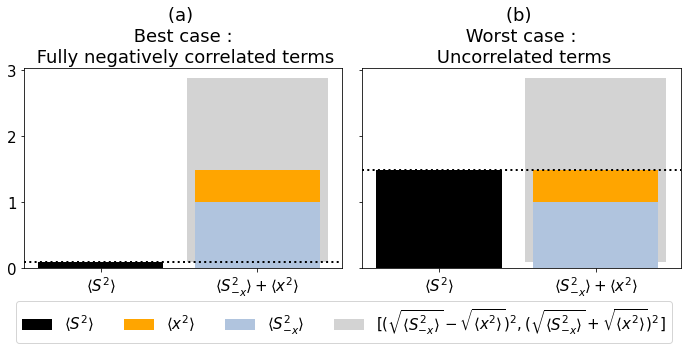

In [19]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5), sharey=True)
ax=ax.flatten()
         
ax[0].bar(0.5, var_sac, color ='k',width = 0.4, zorder=3, label=r'$\langle S^2\rangle$')
ax[0].axhline(y=var_sac, c="k", linewidth=2, ls=':', zorder=4)
ax[0].bar(1, var_e, color ='orange',width = 0.4, zorder=3, bottom=var_a, label=r'$\langle x^2\rangle$')
ax[0].bar(1, var_a, color ='lightsteelblue',width = 0.4, zorder=3, label=r'$\langle S_{-x}^2\rangle$')
ax[0].set_title('(a) \n Best case : \n Fully negatively correlated terms')
ax[0].bar(1, (np.sqrt(var_b) + np.sqrt(var_a))**2,
           color ='lightgrey', width = 0.45, zorder=1, align = 'center', label=r'$[(\sqrt{\langle S_{-x}^2\rangle}-\sqrt{\langle x^2\rangle})^2,(\sqrt{\langle S_{-x}^2\rangle}+\sqrt{\langle x^2\rangle})^2]$')
ax[0].bar(1, (b.std() - a.std())**2,
           color ='w', width = 0.45, zorder=1, align = 'center')

ax[1].bar(0.5, var_suc, color ='k',width = 0.4, zorder=3)
ax[1].axhline(y=var_suc, c="k", linewidth=2, ls=':', zorder=4)
ax[1].bar(1, var_c, color ='orange',width = 0.4, zorder=3, bottom=var_a)
ax[1].bar(1, var_a, color ='lightsteelblue',width = 0.4, zorder=3)
ax[1].set_title('(b) \n Worst case : \n Uncorrelated terms')
ax[1].bar(1, (np.sqrt(var_b) + np.sqrt(var_a))**2,
           color ='lightgrey', width = 0.45, zorder=1, align = 'center')
ax[1].bar(1, (b.std() - a.std())**2,
           color ='w', width = 0.45, zorder=1, align = 'center')
"""""
ax[2].bar(0.5, var_sc, color ='k',width = 0.4, zorder=3)
ax[2].axhline(y=var_sc, c="k", linewidth=2, ls=':', zorder=4)
ax[2].bar(1, var_b, color ='orange',width = 0.4, zorder=3, bottom=var_a)
ax[2].bar(1, var_a, color ='lightsteelblue',width = 0.4, zorder=3)
ax[2].set_title('(c) \n Worst case: \n Fully positively correlated terms')
ax[2].bar(1, (np.sqrt(var_b) + np.sqrt(var_a))**2,
           color ='lightgrey', width = 0.45, zorder=1, align = 'center')
ax[2].bar(1, (b.std() - a.std())**2,
           color ='w', width = 0.45, zorder=1, align = 'center')
"""""
ticks = (r'$\langle S^2 \rangle$',r'$\langle S_{-x}^2\rangle + \langle x^2\rangle$')

for ax in ax:
    ax.set_xticks([0.5, 1], ticks,)

fig.legend( ncol=4,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.1,1,1])#left, bottom, right, top (default is 0,0,1,1)

In [ ]:
ticks = (r'$\langle (a+b)^2\rangle$',r'$\langle a^2\rangle + \langle b^2\rangle$')
    ax.set_xticks(N, ticks,)

In [12]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
